install requirements


In [ ]:
!pip install regelum-control

In [ ]:
from regelum.policy import Policy
from regelum.system import KinematicPoint
from regelum.utils import rg
from regelum.simulator import CasADi
from regelum.callback import (
    ScenarioStepLogger,
    HistoricalDataCallback,
)
from regelum.model import ModelWeightContainer
from regelum.optimizable.core.configs import CasadiOptimizerConfig
from regelum import set_ipython_env
from numpy import ndarray
from regelum.model import Model, ModelNN, ModelQuadLin
from regelum.optimizable.core.configs import OptimizerConfig
from regelum.system import ComposedSystem, System
from regelum.objective import mpc_objective
from regelum.predictor import EulerPredictor
from regelum.objective import RunningObjective
from regelum.data_buffers import DataBuffer
%matplotlib inline

In [2]:
callbacks = [ScenarioStepLogger, HistoricalDataCallback]
ScenarioStepLogger.cooldown = 0.1
callbacks = set_ipython_env(callbacks=callbacks, interactive=True)

## Introduction to Model Predictive Control with Regelum

Model Predictive Control (MPC) is a type of control algorithm that uses an optimization approach to determine the control actions. MPC controls the behavior of a system by solving an optimization problem that minimizes a cost function subject to dynamic constraints and system limitations. It is widely used in industrial processes, robotics, and autonomous vehicles due to its ability to handle multi-variable control problems and constraints.

In this tutorial, we will learn how to implement an MPC algorithm to stabilize a kinematic point to the origin using the Regelum framework. We will focus on a simple dynamic system where a point mass moves along a line, and the control input directly influences its velocity. The system is governed by the equation:

$$
\mathrm{d} \left(
    \begin{array}{c}
        x \\
        y
    \end{array}
    \right) = \left(
    \begin{array}{c}
        v_x \\
        v_y
    \end{array}
    \right)  \mathrm{d}t
$$

Where:

- $\left(\begin{array}{c}x \\ y\end{array}\right)$ is the position of the kinematic point.

- $\left(\begin{array}{c}v_x \\ v_y \end{array}\right)$ is the control action.

Our goal is to design an MPC controller that will bring the point from any initial position to the origin (the point $x=0$) and keep it there.

This tutorial will be presented in a Jupyter Notebook, which combines Markdown text with executable code blocks, making it an interactive learning experience. Jupyter Notebook renders formulas using LaTeX, ensuring that all mathematical expressions are displayed clearly.

Prerequisites:

- Basic understanding of control theory and reinforcement learning concepts.
- Familiarity with Python programming.
- Jupyter Notebook and the Regelum framework installed.

As we proceed, we will be writing Python code snippets, defining mathematical functions, and visualizing our results all within this Jupyter Notebook. Let's get started with implementing MPC and seeing it in action!

## New entities in this tutorial.

### Scenario

The `Scenario` entity is akin to a conductor in an orchestra. It orchestrates the entire feedback loop of an experiment or simulation. It's responsible for managing how different components of the system interact with each other over the course of time or iterations. Within `Scenario`, the state of the system is updated, actions are decided based on current policies, and the learning or control algorithms are given the opportunity to adapt based on the outcomes. In the context of MPC, `Scenario` dictates when the optimization should occur, applies the resulting control actions, and advances the system forward.

Here's an outline of typical responsibilities for `Scenario`:

- Initiating and maintaining the simulation environment or experiment setup.
- Orchestrating interactions between different components such as policies, models, agents, or environments.
- Collecting data, such as states and rewards, to facilitate learning or control adjustments.

### Model

`Model` in Regelum is an abstraction meant to represent parametrized functions or systems which can include, but are not limited to, polynomials, neural networks, or linear models. It is essentially a mathematical representation of a process or component within the framework— for example, a predictive model of system dynamics or a controller's behavior pattern. In the context of MPC, `Model` could encapsulate the control law, forecast future states, or estimate costs.

Characteristics of `Model`:

- It is defined by a set of parameters which can be adjusted during optimization.
- It is a representation used to mimic or predict the behavior of a system or a component.
- It can be simple or complex depending on the needs of the control or learning task. For instance, a simple linear model for a well-understood system, or a deep neural network for a complex, nonlinear one.

### Optimizable

`Optimizable` is an interface or a base class within the Regelum framework, intended for objects that are subject to optimization. When a class inherits from `Optimizable`, it gains the ability to interface with optimization algorithms provided by various libraries such as CasADi, PyTorch, and Scipy optimize. This makes it easier to define and solve optimization problems in a standardized way across different components and domains.

By inheriting from `Optimizable`, a class explicitly indicates that it:

- Has parameters that can be optimized or adjusted.
- Contains or is associated with a cost function or an optimization criterion.
- Can integrate seamlessly with the optimization tools and algorithms offered by Regelum, allowing for methods like `.optimize(...)` to be called to adjust its parameters towards a defined objective.

In the MPC setting, a policy or controller would inherit from `Optimizable` to allow for the ongoing adjustment of control actions to minimize the defined cost function while respecting system constraints.

In Regelum, the components necessary for setting up this optimization problem—such as the definition of the cost function, system dynamics, predictive model, and constraints—need to be implemented leveraging the framework's structures like `Model` and `Optimizable`. Once defined, Regelum will handle the repeated optimization efficiently, integrating with compatible optimization libraries.

In [3]:
PREDICTION_HORIZON = 10
SAMPLING_TIME = 0.01

model = ModelWeightContainer(
    dim_output=2, weights_init=rg.zeros((PREDICTION_HORIZON + 1, 2), rc_type=rg.CASADI)
)  # A trivial model contains our predicted actions
system = KinematicPoint()
predictor = EulerPredictor(
    system=system, pred_step_size=SAMPLING_TIME * 3
)  # Predictor is used for
running_objective_model = ModelQuadLin(
    quad_matrix_type="diagonal", dim_inputs=2, weights=[10, 10, 0, 0]
)  # A quadratic model for running (a.k.a. instant) objective. We penalize our agent for x and y
running_objective = RunningObjective(
    model=running_objective_model
)  # Wrap `running_objective_model` into `RunningObjective` class


class MPC(Policy):

    def __init__(
        self,
        model: Model | ModelNN = model,
        system: System | ComposedSystem = system,
        action_bounds: list | ndarray | None = system.action_bounds,
        optimizer_config: OptimizerConfig | None = CasadiOptimizerConfig(),
        discount_factor: float | None = 1,
        epsilon_random_parameter: float | None = None,
        prediction_horizon: int = PREDICTION_HORIZON,
        running_objective: RunningObjective = running_objective,
        predictor: EulerPredictor = predictor,
    ):
        """Instantiate MPC policy."""
        super().__init__(
            model,
            system,
            action_bounds,
            optimizer_config,
            discount_factor,
            epsilon_random_parameter,
        )  # Initialize the parent `Policy` class.

        self.prediction_horizon = prediction_horizon
        self.running_objective = running_objective
        self.predictor = predictor
        ###### Define the optimization problem
        self.observation_var = self.create_variable(
            1,  # dimensionality of axis 0
            self.system.dim_observation,  # dimensionality of axis 1
            name="observation",
            is_constant=True,  # is_constant set to `True` as `observation` is a constant parameter of optimization
        )
        self.est_state_var = self.create_variable(
            1,  # dimensionality of axis 0
            self.system.dim_observation,  # dimensionality of axis 1
            name="estimated_state",
            is_constant=True,  # is_constant is set to `True` as `estimated_state` is a constant parameter of optimization
        )
        self.policy_model_weights_var = self.create_variable(
            name="policy_model_weights",
            is_constant=False,  # is_constant is set to False because policy_model_weights is a decision variable in our optimization problem
            like=self.model.named_parameters,  # like parameter utilizes the dimensions of the model's weights for compatibility
        )
        ## Let us register bounds for policy model weights to be within action bounds
        (
            self.action_bounds_tiled,
            self.action_initial_guess,
            self.action_min,
            self.action_max,
        ) = self.handle_bounds(
            self.action_bounds,
            self.dim_action,
            tile_parameter=self.model.weights.shape[0],
        )
        self.register_bounds(self.policy_model_weights_var, self.action_bounds_tiled)

        ## Make `Optimizable` aware of objective function and variables it depends on
        self.register_objective(
            self.cost,
            variables=[
                self.observation_var,
                self.est_state_var,
                self.policy_model_weights_var,
            ],
        )

    def optimize(self, databuffer: DataBuffer) -> None:
        """Define optimization routine for `Optimizable` class."""
        new_weights = super().optimize_symbolic(
            **databuffer.get_optimization_kwargs(
                keys=["observation", "estimated_state"],
                optimizer_config=self.optimizer_config,
            ),
            policy_model_weights=self.policy_model_weights_var(),
        )[
            "policy_model_weights"
        ]  # Get the optimized weights from `Optimizable` class
        self.model.update_and_cache_weights(new_weights)

    def cost(self, observation, estimated_state, policy_model_weights):
        """Cost function for MPC Policy."""
        return mpc_objective(
            observation=observation,
            estimated_state=estimated_state,
            policy_model_weights=policy_model_weights,
            discount_factor=self.discount_factor,
            running_objective=self.running_objective,
            prediction_horizon=self.prediction_horizon,
            predictor=self.predictor,
            model=self.model,
        )  # Call `mpc_objective` function to get the cost of current state and sequence of predicted actions

## Run it!

In [4]:
from regelum.critic import CriticTrivial
from regelum.scenario import RLScenario
from regelum.event import Event


simulator = CasADi(
    system=system,
    state_init=rg.array([-10, 10]),
    action_init=rg.array([0]),
    max_step=1e-3,
    first_step=1e-6,
    atol=1e-5,
    rtol=1e-3,
)

scenario = RLScenario(
    policy=MPC(),
    critic=CriticTrivial(),  # mocked critic
    running_objective=running_objective,
    policy_optimization_event=Event.compute_action,  # run policy optimization on each step
    discount_factor=1.0,
    sampling_time=SAMPLING_TIME,
    simulator=simulator,
    N_episodes=1,
    N_iterations=1,
)

In [5]:
scenario.run()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



[19:56:44] INFO     runn. objective: 2000.00, state est.: [-10  10], observation: [-10  10],       ]8;id=80385;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=169856;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 20.0000, time: 0.0000 (0.0%), episode: 1/1,                        
                    iteration: 1/1                                                                                 

           INFO     runn. objective: 1620.00, state est.: [-9.  9.], observation: [-9.  9.],       ]8;id=598561;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=646795;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 198.7700, time: 0.1000 (10.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

           INFO     runn. objective: 1248.20, state est.: [-7.9  7.9], observation: [-7.9  7.9],   ]8;id=236764;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=564136;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 354.2220, time: 0.2100 (21.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

           INFO     runn. objective: 924.80, state est.: [-6.8  6.8], observation: [-6.8  6.8],    ]8;id=245978;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=782971;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 471.6800, time: 0.3200 (32.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

           INFO     runn. objective: 649.80, state est.: [-5.7  5.7], observation: [-5.7  5.7],    ]8;id=71968;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=839725;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 556.4680, time: 0.4300 (43.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

           INFO     runn. objective: 423.20, state est.: [-4.6  4.6], observation: [-4.6  4.6],    ]8;id=874718;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=586230;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 613.9100, time: 0.5400 (54.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

           INFO     runn. objective: 245.00, state est.: [-3.5  3.5], observation: [-3.5  3.5],    ]8;id=402561;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=310374;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 649.3300, time: 0.6500 (65.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

           INFO     runn. objective: 125.00, state est.: [-2.5  2.5], observation: [-2.5  2.5],    ]8;id=471929;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=246896;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 666.9000, time: 0.7500 (75.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

           INFO     runn. objective: 45.00, state est.: [-1.5  1.5], observation: [-1.5  1.5],     ]8;id=707404;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=82906;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 674.6700, time: 0.8500 (85.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

           INFO     runn. objective: 3.20, state est.: [-0.4  0.4], observation: [-0.4  0.4],      ]8;id=755559;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=376375;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 676.6720, time: 0.9600 (96.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

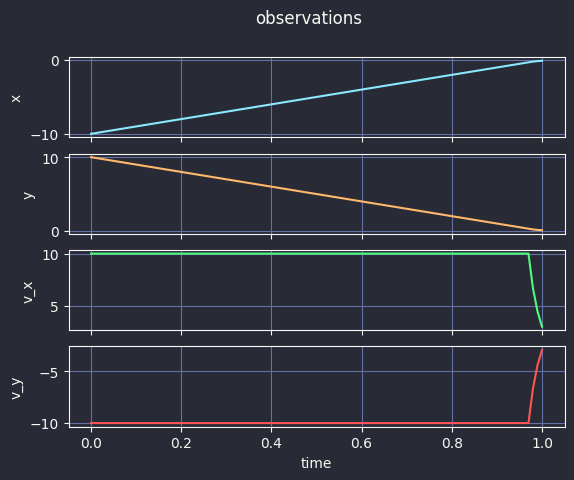

In [6]:
historical_callback = callbacks[1]
historical_callback.plot(name="observations")

In [7]:
historical_callback.clear_recent_data()

## MPC with constraints

Now, assume we have an obstacle in our environment that should be avoided by our agent. One way to achieve it is to define a set of constraints what should be taken into account by our policy.
Consider our environment has a constraint of the following form:
$$
(x + 2) ^ 2 + (y - 2) ^ 2 \leq 0.5  
$$
Let's see how we can change the definition of our MPC problem to take this constraint into account.

In [8]:
from regelum.constraint_parser import (
    CylindricalHalfPlaneConstraintParser,
    ConstraintParser,
)

In [9]:
class ConstrainedMPC(MPC):
    def __init__(self, constraint_parser: ConstraintParser, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.constraint_parser = constraint_parser

        self.predicted_states_var = self.create_variable(
            self.prediction_horizon,
            self.system.dim_state,
            name="predicted_states",
            is_nested_function=True,
            nested_variables=[self.policy_model_weights_var],
        )
        self.connect_source(
            connect_to=self.predicted_states_var,
            func=self.predictor.predict_state_sequence_from_model,
            prediction_horizon=self.prediction_horizon,
            state=self.est_state_var,
            model=self.model,
            model_weights=self.policy_model_weights_var,
            is_predict_last=False,
            return_predicted_states_only=True,
        )
        self.constraint_parameters = [
            self.create_variable(
                *parameter.dims, name=parameter.name, is_constant=True
            ).with_data(parameter.data)
            for parameter in self.constraint_parser
        ]
        self.register_constraint(
            self.constraint_parser.constraint_function,
            variables=[self.predicted_states_var, *self.constraint_parameters],
        )


constraint_parser = CylindricalHalfPlaneConstraintParser(
    centers=rg.array([[-2, 2]]), coefs=rg.array([[1, 1]]), radii=rg.array([[0.5]])
)

In [10]:
simulator = CasADi(
    system=system,
    state_init=rg.array([-10, 10]),
    action_init=rg.array([0]),
    max_step=1e-3,
    first_step=1e-6,
    atol=1e-5,
    rtol=1e-3,
    time_final=1,
)

scenario = RLScenario(
    policy=ConstrainedMPC(constraint_parser=constraint_parser),
    critic=CriticTrivial(),
    running_objective=running_objective,
    policy_optimization_event=Event.compute_action,
    discount_factor=1.0,
    sampling_time=SAMPLING_TIME,
    simulator=simulator,
    N_episodes=1,
    N_iterations=1,
)

In [11]:
scenario.run()

[19:56:45] INFO     runn. objective: 2000.00, state est.: [-10  10], observation: [-10  10],       ]8;id=400617;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=269339;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 20.0000, time: 0.0000 (0.0%), episode: 1/1,                        
                    iteration: 1/1                                                                                 

           INFO     runn. objective: 1620.00, state est.: [-9.  9.], observation: [-9.  9.],       ]8;id=792941;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=535996;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 198.7700, time: 0.1000 (10.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

           INFO     runn. objective: 1248.20, state est.: [-7.9  7.9], observation: [-7.9  7.9],   ]8;id=479571;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=572418;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 354.2220, time: 0.2100 (21.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

           INFO     runn. objective: 924.80, state est.: [-6.8  6.8], observation: [-6.8  6.8],    ]8;id=51561;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=963922;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 471.6800, time: 0.3200 (32.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

           INFO     runn. objective: 649.80, state est.: [-5.7  5.7], observation: [-5.7  5.7],    ]8;id=463720;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=11205;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 556.4680, time: 0.4300 (43.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

[19:56:47] INFO     runn. objective: 500.00, state est.: [-5.  5.], observation: [-5.  5.],        ]8;id=546768;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=485458;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 595.8500, time: 0.5000 (50.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

[19:56:49] INFO     runn. objective: 460.80, state est.: [-4.8  4.8], observation: [-4.8  4.8],    ]8;id=855086;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=682219;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 605.2601, time: 0.5200 (52.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

[19:56:51] INFO     runn. objective: 441.81, state est.: [-4.7  4.7], observation: [-4.7  4.7],    ]8;id=50962;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=701144;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 609.6781, time: 0.5300 (53.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

[19:56:53] INFO     runn. objective: 405.01, state est.: [-4.5  4.5], observation: [-4.5  4.5],    ]8;id=660832;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=530240;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 617.9603, time: 0.5500 (55.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

[19:56:55] INFO     runn. objective: 387.21, state est.: [-4.4  4.4], observation: [-4.4  4.4],    ]8;id=722887;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=792143;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 9.99 -9.99], value: 621.8324, time: 0.5600 (56.0%), episode: 1/1,                    
                    iteration: 1/1                                                                                 

[19:56:57] INFO     runn. objective: 352.83, state est.: [-4.2  4.2], observation: [-4.2  4.2],    ]8;id=62554;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=88635;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 9.99 -9.99], value: 629.0589, time: 0.5800 (58.0%), episode: 1/1,                    
                    iteration: 1/1                                                                                 

[19:56:59] INFO     runn. objective: 336.24, state est.: [-4.1  4.1], observation: [-4.1  4.1],    ]8;id=325874;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=668041;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 9.99 -9.99], value: 632.4213, time: 0.5900 (59.0%), episode: 1/1,                    
                    iteration: 1/1                                                                                 

[19:57:01] INFO     runn. objective: 304.25, state est.: [-3.9  3.9], observation: [-3.9  3.9],    ]8;id=559945;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=401659;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 9.99 -9.99], value: 638.6644, time: 0.6100 (61.0%), episode: 1/1,                    
                    iteration: 1/1                                                                                 

[19:57:03] INFO     runn. objective: 288.87, state est.: [-3.8  3.8], observation: [-3.8  3.8],    ]8;id=439334;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=230015;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [10.   -9.99], value: 641.5530, time: 0.6200 (62.0%), episode: 1/1,                    
                    iteration: 1/1                                                                                 

[19:57:05] INFO     runn. objective: 259.27, state est.: [-3.6  3.6], observation: [-3.6  3.6],    ]8;id=635840;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=478087;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 9.99 -9.99], value: 646.8845, time: 0.6400 (64.0%), episode: 1/1,                    
                    iteration: 1/1                                                                                 

[19:57:07] INFO     runn. objective: 245.09, state est.: [-3.5  3.5], observation: [-3.5  3.5],    ]8;id=622434;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=602655;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 9.98 -9.99], value: 649.3354, time: 0.6500 (65.0%), episode: 1/1,                    
                    iteration: 1/1                                                                                 

[19:57:09] INFO     runn. objective: 217.90, state est.: [-3.3  3.3], observation: [-3.3  3.3],    ]8;id=584541;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=246468;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [  9.98 -10.  ], value: 653.8274, time: 0.6700 (67.0%), episode: 1/1,                  
                    iteration: 1/1                                                                                 

[19:57:11] INFO     runn. objective: 204.91, state est.: [-3.2  3.2], observation: [-3.2  3.2],    ]8;id=821840;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=635304;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 9.98 -9.99], value: 655.8765, time: 0.6800 (68.0%), episode: 1/1,                    
                    iteration: 1/1                                                                                 

[19:57:13] INFO     runn. objective: 180.12, state est.: [-3.  3.], observation: [-3.  3.],        ]8;id=853850;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=991877;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 9.97 -9.99], value: 659.6010, time: 0.7000 (70.0%), episode: 1/1,                    
                    iteration: 1/1                                                                                 

[19:57:15] INFO     runn. objective: 168.34, state est.: [-2.9  2.9], observation: [-2.9  2.9],    ]8;id=858771;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=762699;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 9.99 -9.93], value: 661.2844, time: 0.7100 (71.0%), episode: 1/1,                    
                    iteration: 1/1                                                                                 

           INFO     runn. objective: 156.99, state est.: [-2.8  2.8], observation: [-2.8  2.8],    ]8;id=904258;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=515608;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 662.8543, time: 0.7200 (72.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

[19:57:17] INFO     runn. objective: 145.98, state est.: [-2.7  2.7], observation: [-2.7  2.7],    ]8;id=473693;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=900377;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 9.92 -9.97], value: 664.3140, time: 0.7300 (73.0%), episode: 1/1,                    
                    iteration: 1/1                                                                                 

[19:57:19] INFO     runn. objective: 135.43, state est.: [-2.6  2.6], observation: [-2.6  2.6],    ]8;id=87582;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=933860;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 9.89 -9.99], value: 665.6683, time: 0.7400 (74.0%), episode: 1/1,                    
                    iteration: 1/1                                                                                 

[19:57:21] INFO     runn. objective: 115.47, state est.: [-2.4  2.4], observation: [-2.4  2.4],    ]8;id=452036;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=826179;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 9.99 -3.28], value: 668.0759, time: 0.7600 (76.0%), episode: 1/1,                    
                    iteration: 1/1                                                                                 

[19:57:23] INFO     runn. objective: 109.21, state est.: [-2.3   2.37], observation: [-2.3         ]8;id=475820;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=339029;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    2.37], action: [ 9.99 -0.1 ], value: 669.1679, time: 0.7700 (77.0%), episode:                  
                    1/1, iteration: 1/1                                                                            

[19:57:25] INFO     runn. objective: 104.65, state est.: [-2.2   2.37], observation: [-2.2         ]8;id=184331;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=181360;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    2.37], action: [9.99 2.04], value: 670.2144, time: 0.7800 (78.0%), episode:                    
                    1/1, iteration: 1/1                                                                            

           INFO     runn. objective: 52.14, state est.: [-1.3   1.87], observation: [-1.3   1.87], ]8;id=989628;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=713520;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 677.3462, time: 0.8700 (87.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

           INFO     runn. objective: 8.57, state est.: [-0.3   0.87], observation: [-0.3   0.87],  ]8;id=749275;file:///mnt/md0/rcognita/regelum/callback.py\callback.py]8;;\:]8;id=599338;file:///mnt/md0/rcognita/regelum/callback.py#1095\1095]8;;\
                    action: [ 10. -10.], value: 679.8341, time: 0.9700 (97.0%), episode: 1/1,                      
                    iteration: 1/1                                                                                 

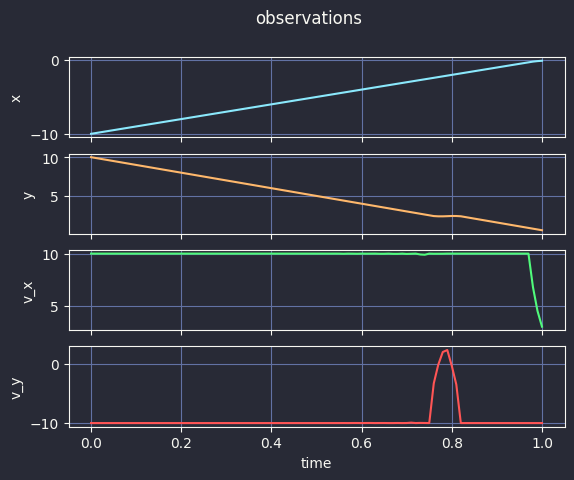

In [12]:
historical_callback = callbacks[1]
historical_callback.plot(name="observations")

In [13]:
historical_callback.clear_recent_data()